In [1]:
import gzip
import sklearn
from sklearn import linear_model
from collections import defaultdict
import random
import math
import numpy as np
from sklearn.metrics import jaccard_score as jaccard
import pandas as pd
import os
import matplotlib.pyplot as plt

# * RecSys.pdf contains write up for assignment 

# Tasks (Play prediction)
### Play prediction (both classes) 
#### Predict given a (user,game) pair from ‘pairs Played.txt’ whether the user would play the game (0 or 1). Accuracy will be measured in terms of the categorization accuracy (fraction of correct predictions). The test set has been constructed such that exactly 50% of the pairs correspond to played games and the other 50% do not.

In [2]:
def parse(f):
    for l in gzip.open(f):
        yield eval(l)

In [3]:
train_json = list(parse("data/train.json.gz"))

In [4]:
train_json[1]

{'userID': 'u88836191',
 'early_access': False,
 'hours': 63.5,
 'hours_transformed': 6.011227255423254,
 'found_funny': 1,
 'text': 'If you want to sit in queue for 10-20min and have 140 ping then this game is perfect for you :)',
 'gameID': 'b19457938',
 'user_id': '76561198030408772',
 'date': '2017-05-20'}

In [5]:
df = pd.DataFrame(train_json)

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df['year'] = df['date'].dt.year

In [8]:
df['month'] = df['date'].dt.month

In [9]:
df['year'].value_counts()

2017    49848
2016    43667
2015    37646
2014    27357
2013     8910
2012     3376
2011     2659
2018     1034
2010      503
Name: year, dtype: int64

In [10]:
data = [[d['userID'],d['gameID'],1] for d in train_json]

split = 165000
train = train_json[:split]
ug_train = [[d['userID'],d['gameID'],1] for d in train]
validation = train_json[split:]
ug_valid = [[d['userID'],d['gameID'],1] for d in validation]

In [11]:
def readJSON(path):
  for l in gzip.open(path, 'rt'):
    d = eval(l)
    u = d['userID']
    try:
      g = d['gameID']
    except Exception as e:
      g = None
    yield u,g,d

##### Cells below for Kaggle comptetition

In [12]:
### Time-played baseline: compute averages for each user, or return the global average if we've never seen the user before

# allHours = []
# userHours = defaultdict(list)

# for user,game,d in readJSON("data/train.json.gz"):
#   h = d['hours_transformed']
#   allHours.append(h)
#   userHours[user].append(h)

# globalAverage = sum(allHours) / len(allHours)
# userAverage = {}
# for u in userHours:
#   userAverage[u] = sum(userHours[u]) / len(userHours[u])

In [13]:
# predictions = open("predictions_Hours.txt", 'w')
# for l in open("data/pairs_Hours.txt"):
#   if l.startswith("userID"):
#     #header
#     predictions.write(l)
#     continue
#   u,g = l.strip().split('-')
#   if u in userAverage:
#     predictions.write(u + '-' + g + ',' + str(userAverage[u]) + '\n')
#   else:
#     predictions.write(u + '-' + g + ',' + str(globalAverage) + '\n')

# predictions.close()

In [14]:
### Would-play baseline: just rank which games are popular and which are not, and return '1' if a game is among the top-ranked

# gameCount = defaultdict(int)
# totalPlayed = 0

# for user,game,_ in readJSON("data/train.json.gz"):
#   gameCount[game] += 1
#   totalPlayed += 1

# mostPopular = [(gameCount[x], x) for x in gameCount]
# mostPopular.sort()
# mostPopular.reverse()

# return1 = set()
# count = 0
# for ic, i in mostPopular:
#   count += ic
#   return1.add(i)
#   if count > totalPlayed/2: break

In [15]:
# predictions = open("predictions_Played.txt", 'w')
# for l in open("data/pairs_Played.txt"):
#   if l.startswith("userID"):
#     #header
#     predictions.write(l)
#     continue
#   u,g = l.strip().split('-')
#   if g in return1:
#     predictions.write(u + '-' + g + ",1\n")
#   else:
#     predictions.write(u + '-' + g + ",0\n")

# predictions.close()

In [16]:
# ### Category prediction baseline: Just consider some of the most common words from each category

# catDict = {
#   "Action": 0,
#   "Strategy": 1,
#   "RPG": 2,
#   "Adventure": 3,
#   "Sport": 4
# }

# predictions = open("predictions_Category.txt", 'w')
# predictions.write("userID-reviewID,prediction\n")
# for u,_,d in readJSON("data/test_Category.json.gz"):
#   cat = catDict['Action'] # If there's no evidence, just choose the most common category in the dataset
#   words = d['text'].lower()
#   if 'strategy' in words:
#     cat = catDict['Strategy']
#   if 'rpg' in words:
#     cat = catDict['RPG']
#   if 'adventure' in words:
#     cat = catDict['Adventure']
#   if 'sport' in words:
#     cat = catDict['Sport']
#   predictions.write(u + '-' + d['reviewID'] + "," + str(cat) + "\n")

# predictions.close()

#### Task 1 - generate *negative entries* to build training and test set

In [17]:
#gets users per game and games per user from entire dataset
usersPerGame = defaultdict(set)
gamesPerUser = defaultdict(set)
#collects all unique games in the dataset
uniqueGames = set()

for d in data:
    u, g = d[0], d[1]
    usersPerGame[g].add(u)
    gamesPerUser[u].add(g)
    uniqueGames.add(g)

In [18]:
users_valid = [d[0] for d in ug_valid]
users_train = [d[0] for d in ug_train]

In [19]:
ug_valid_neg= []
for u in users_valid:
    gamesNotPlayed = uniqueGames - gamesPerUser[u]
    randomGame = random.choice(list(gamesNotPlayed))
    ug_valid_neg.append([u, randomGame,0])

    
ug_train_neg= []
for u in users_train:
    gamesNotPlayed = uniqueGames - gamesPerUser[u]
    randomGame = random.choice(list(gamesNotPlayed))
    ug_train_neg.append([u, randomGame,0])
    

In [20]:
ug_valid_build = ug_valid + ug_valid_neg
ug_train_build = ug_train + ug_train_neg

In [21]:
ug_valid_build[9995:10005]

[['u90835702', 'b62891570', 1],
 ['u40505592', 'b75563467', 1],
 ['u67709233', 'b14676161', 1],
 ['u79727950', 'b36105300', 1],
 ['u25903175', 'b50879604', 1],
 ['u49969792', 'b03148978', 0],
 ['u33147591', 'b27897741', 0],
 ['u00954406', 'b36463329', 0],
 ['u40416473', 'b30552994', 0],
 ['u08125051', 'b58508951', 0]]

In [22]:
len(ug_valid_build)

20000

In [23]:
Xvalid = [[d[0],d[1]] for d in ug_valid_build]
yvalid = [d[2] for d in ug_valid_build]

Xtrain = [[d[0], d[1]] for d in ug_train_build]
ytrain = [d[2] for d in ug_train_build]

In [24]:
### Would-play baseline: just rank which games are popular and which are not, and return '1' if a game is among the top-ranked
##task 1 baseline
def baselinePreds(Xvalid, threshold):
    gameCount = defaultdict(int)
    totalPlayed = 0

    for user,game,_ in readJSON("data/train.json.gz"):
      gameCount[game] += 1
      totalPlayed += 1
 
        

    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
      count += ic
      return1.add(i)
      if count > totalPlayed/threshold: break


    #task 1 predictions
    predictions = []
    for user, game in Xvalid:
        if game in return1:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

In [25]:
def computeAccuracy(preds, true):  
    correct = np.array(preds) == np.array(true)
    return sum(correct) / len(correct)


In [26]:
preds = baselinePreds(Xvalid,2)

#### baseline accuracy

In [27]:
#accuracy of baseline model on validation set
th2_acc = computeAccuracy(preds, yvalid)
print(computeAccuracy(preds, yvalid))

0.68055


#### Task 2 - find an optimal popularity threshold

#### my choice for thresholds was to keep it low, and see if being more selective in terms of popularity percentile would yield a better model, as you can see it performed slightly better in terms of accuracy

In [28]:
# my choice for thresholds was to keep it low, and see if being more selective 
#in terms of popularity percentile would yield a better model

def bestThreshold():
    best_th = 2
    best_acc = th2_acc
    for i in np.arange(1,2.05,.01):
        acc = computeAccuracy(baselinePreds(Xvalid,i), yvalid)
        if acc > best_acc:
            best_th = i
            best_acc = acc
    return best_th, best_acc

x = bestThreshold()
print(x)

(1.5200000000000005, 0.7011)


In [29]:
best_popth = x[0]
print(best_popth)

1.5200000000000005


#### Task 3 - build Jaccard similarity based recommender system

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [32]:
#all users for a specific game in training data
#all games for a specific user in training data
usersPerGame = defaultdict(set)
gamesPerUser = defaultdict(set)
for u,g in Xtrain:
    usersPerGame[g].add(u)
    gamesPerUser[u].add(g)

In [33]:
#testing different implementation
def mostSimilar(u, g):
    similarities = []
    games = gamesPerUser[u]
    for g2 in games:
        if g2 == g:continue
        sim = Jaccard(usersPerGame[g], usersPerGame[g2])
        similarities.append(sim)
    similarities.sort(reverse=True)
    return similarities[:10]

In [34]:
def similarityScores(user, game):
    #consider g' in training set that a user has played
    g_primes = gamesPerUser[user]
    similarities = []
    
    if len(g_primes) == 0:
        similarities.append(0)
        return similarities
    
    for g_prime in g_primes:
        if g_prime == game:
            continue
        #users in training data who have played g
        ugTrain = usersPerGame[game]
        #users who have played g'
        ugPrime = usersPerGame[g_prime]
        if len(ugPrime) == 0:
            similarities.append(0)
        if len(ugTrain) == 0:
            similarities.append(0)
        else:
            similarities.append(Jaccard(ugTrain,ugPrime))
    
        
        
    similarities.sort(reverse= True)   
    return similarities[:10]

In [35]:
#item-item similarity implementation
def i_similarityScores(user, game):
    #consider g' in training set that a user has played
    u_primes = usersPerGame[game]
    similarities = []
            
    #item to titem
    if len(u_primes) == 0:
        similarities.append(0)
        return similarities
    
    for u_prime in u_primes:
        if u_prime == user:
            continue
        #users in training data who have played g
        ugTrain = gamesPerUser[user]
        #users who have played g'
        ugPrime = gamesPerUser[u_prime]
        if len(ugPrime) == 0:
            similarities.append(0)
        else:
            similarities.append(Jaccard(ugTrain,ugPrime))
    
        
    similarities.sort(reverse= True)
    
    return similarities[:10]

In [36]:
max_scores = []
for user, game in Xvalid:
    max_scores.append(np.max(similarityScores(user, game)))

In [37]:
# max_scores_fast = []
# for user, game in Xvalid:
#     msf = mostSimilarFast(game)
#     max_scores_fast.append(np.max(msf))

In [38]:
i_max_scores = []
for user, game in Xvalid:
    i_max_scores.append(np.max(i_similarityScores(user, game)))

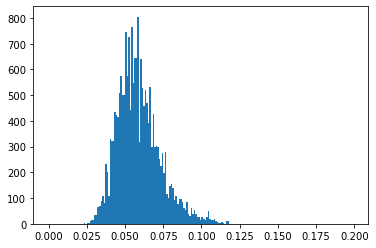

In [39]:
plt.hist(i_max_scores, bins = np.arange(0,.2,.001))
plt.show()

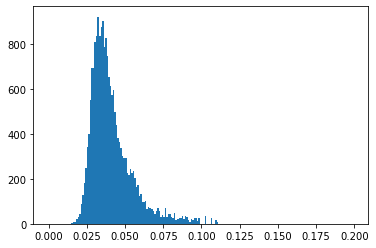

In [40]:
plt.hist(max_scores, bins = np.arange(0,.2,.001))
plt.show()

In [41]:
def jaccard_preds(max_scores,th):
    predictions = []
    for sim in max_scores:
        if sim > th:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [42]:
def bestThreshold():
    best_th = 0
    best_acc = 0
    for th in np.arange(0,.1,.001):
        preds = jaccard_preds(max_scores,th)
        acc = computeAccuracy(preds, yvalid)
        if acc > best_acc:
            best_th = th
            best_acc = acc
            
    return (best_th, best_acc)
best_jacc = bestThreshold()

In [43]:
best_jacc

(0.041, 0.66515)

In [44]:
best_jth = best_jacc[0]
best_jth

0.041

In [45]:
def i_bestThreshold():
    best_th = 0
    best_acc = 0
    for th in np.arange(0,.125,.001):
        preds = jaccard_preds(i_max_scores,th)
        acc = computeAccuracy(preds, yvalid)
        if acc > best_acc:
            best_th = th
            best_acc = acc
            
    return (best_th, best_acc)
#item to item results
x = i_bestThreshold()
print(x)

(0.055, 0.56925)


In [46]:
best_ijth = x[0]
print(best_ijth)

0.055


In [47]:
# #using mostSimilarFast implementation
# def bestThreshold():
#     best_th = 0
#     best_acc = 0
#     for th in np.arange(0.025,.175,.001):
#         preds = jaccard_preds(max_scores_fast,th)
#         acc = computeAccuracy(preds, yvalid)
#         if acc > best_acc:
#             best_th = th
#             best_acc = acc
            
#     return (best_th, best_acc)
# x = bestThreshold()

#### Task 4 - Improve the above predictor by incorporating both a Jaccard-based threshold and a popularity based threshold.

In [48]:
def baselinePreds4(ug_valid_build, j_th,pop_th):
    gameCount = defaultdict(int)
    totalPlayed = 0

    for user,game,_ in readJSON("data/train.json.gz"):
        gameCount[game] += 1
        totalPlayed += 1

    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalPlayed/pop_th: break


    predictions_or = []
    for user, game, _ in ug_valid_build:
        mostSim = similarityScores(user, game)
        if (game in return1) or (max(mostSim) >= j_th):
            predictions_or.append(1)
        else:
            predictions_or.append(0)
            
    predictions_and = []
    for user, game, _ in ug_valid_build:
        mostSim = similarityScores(user, game)
        if (game in return1) and (max(mostSim) >= j_th):
            predictions_and.append(1)
        else:
            predictions_and.append(0)
    return predictions_and, predictions_or

In [49]:
preds_and,preds_or = baselinePreds4(ug_valid_build,best_jth,best_popth)
and_acc = computeAccuracy(preds_and, yvalid)
or_acc = computeAccuracy(preds_or, yvalid)
print(and_acc)
print(or_acc)

0.677
0.68925


In [50]:
preds_and,preds_or = baselinePreds4(ug_valid_build,.031,1.52)
and_acc = computeAccuracy(preds_and, yvalid)
or_acc = computeAccuracy(preds_or, yvalid)
print(and_acc)
print(or_acc)

0.7009
0.59255


In [51]:
preds_and,preds_or = baselinePreds4(ug_valid_build,.030,1.5)
and_acc = computeAccuracy(preds_and, yvalid)
or_acc = computeAccuracy(preds_or, yvalid)
print(and_acc)
print(or_acc)

0.7004
0.57995


In [52]:
# best_jth = .031
# best_popth = 1.52

#### redesign model
##### when passing the best threshold from q2 and q3 into the function above i mistyped one of the thresholds and managed to get an unexpected accuracy, so I ran a script to see if combining different jaccard-based thresholds and popularity thresholds would give better accuracy, or if the optimal thresholds from q2 and q3 were still the best, unfortunately the run time was a couple of hours because I was testing a large range of every possible combination for jaccard/popularity thresholds, i also redid some of the conditional statements for a more lenient predictor
##### the pseudo code for finding a better threshold combo is having two for loops, one outer and one nested, one loops through a range in jaccard thresholds and the other loops through some popularity threshold, then i run baselinePreds4 passing in those thresholds, compute accuracies and print out the accuracies with the thresholds to see which combo gives the best result in the redesigned baseline predictor

In [53]:
from tqdm import tqdm

In [54]:
def baselinePreds4(ug_valid_build, j_th,pop_th):
    gameCount = defaultdict(int)
    totalPlayed = 0

    usersPerGame = defaultdict(set)
    gamesPerUser = defaultdict(set)

    
    for user,game,_ in readJSON("data/train.json.gz"):
        gameCount[game] += 1
        totalPlayed += 1
        usersPerGame[g].add(u)
        gamesPerUser[u].add(g)

    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalPlayed/pop_th: break

            
    predictions_and = []
    for user, game, _ in ug_valid_build:
        mostSim = similarityScores(user, game)
        if (game in return1):
            predictions_and.append(1)
        elif game in gamesPerUser[user]:
            predictions_and.append(1)
        else:
            if (game not in return1) and (max(mostSim) >= j_th):
                predictions_and.append(1)
            else:
                predictions_and.append(0)
    return predictions_and



In [55]:
preds_and = baselinePreds4(ug_valid_build,best_jth,best_popth)
and_acc = computeAccuracy(preds_and, yvalid)
print(and_acc)

0.68925


In [56]:
preds_and = baselinePreds4(ug_valid_build,.048,1.55)
and_acc = computeAccuracy(preds_and, yvalid)
print(and_acc)

0.6991


In [57]:
preds_and = baselinePreds4(ug_valid_build,.04,1.52)
and_acc = computeAccuracy(preds_and, yvalid)
print(and_acc)

0.6843


In [58]:
#>=
preds_and = baselinePreds4(ug_valid_build,.048,1.52)
and_acc = computeAccuracy(preds_and, yvalid)
print(and_acc)

0.6994


In [59]:
preds_and = baselinePreds4(ug_valid_build,.048,1.51)
and_acc = computeAccuracy(preds_and, yvalid)
print(and_acc)

0.69865


In [60]:
best_jth = .031
best_popth =1.52

def baselinePreds4(ug_valid_build, j_th,pop_th):
    gameCount = defaultdict(int)
    totalPlayed = 0

    for user,game,_ in readJSON("data/train.json.gz"):
        gameCount[game] += 1
        totalPlayed += 1

    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    game_pop = defaultdict(float)
    for ic, i in mostPopular:
        count += ic
        game_pop[i] = 1 - (count/totalPlayed)
        return1.add(i)
        if count > totalPlayed/pop_th: break


#     predictions_or = []
#     for user, game, _ in ug_valid_build:
#         mostSim = similarityScores(user, game)
#         if (game in return1) or (max(mostSim) >= j_th):
#             predictions_or.append(1)
#         else:
#             predictions_or.append(0)
            
    predictions_and = []
    for user, game, _ in ug_valid_build:
        mostSim = similarityScores(user, game)
        if (game in return1) and (max(mostSim) >= j_th):
            predictions_and.append(1)
        else:
            predictions_and.append(0)
    return predictions_and



In [61]:
#user-user similarity
def similarityScores(user, game):
    #consider g' in training set that a user has played
    g_primes = gamesPerUser[user]
    similarities = []
    
    if len(g_primes) == 0:
        similarities.append(0)
        return similarities
    
    for g_prime in g_primes:
        if g_prime == game:
            continue
        #users in training data who have played g
        ugTrain = usersPerGame[game]
        #users who have played g'
        ugPrime = usersPerGame[g_prime]
        if len(ugPrime) == 0:
            similarities.append(0)
        if len(ugTrain) == 0:
            similarities.append(0)
        else:
            similarities.append(Jaccard(ugTrain,ugPrime))
    
    similarities.sort(reverse= True)
    
    return similarities[:10]


In [62]:
#item-item similarity
def i_similarityScores(user, game):
    #consider all u' in training set that have played game
    u_primes = usersPerGame[game]
    similarities = []
            
    #item to titem
    if len(u_primes) == 0:
        similarities.append(0)
        return similarities
    #for user' in u'
    for u_prime in u_primes:
        if u_prime == user:
            continue
        #games in training data played by user
        ugTrain = gamesPerUser[user]
        #games played by user'
        ugPrime = gamesPerUser[u_prime]
        if len(ugPrime) == 0:
            similarities.append(0)
        if len(ugTrain) == 0:
            similarities.append(0)
        else:
            similarities.append(Jaccard(ugTrain,ugPrime))
    
        
    similarities.sort(reverse= True)
    
    return similarities[:10]

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
train_json[0]

{'hours': 0.3,
 'gameID': 'b96045472',
 'hours_transformed': 0.37851162325372983,
 'early_access': False,
 'date': '2015-04-08',
 'text': '+1',
 'userID': 'u01561183'}

In [65]:
# split = 165000
# data = [[d['userID'],d['gameID'],1] for d in train_json]
# train = train_json[:split]
# ug_train = [[d['userID'],d['gameID'],d['hours_transformed'],1] for d in train]
# validation = train_json[split:]
# ug_valid = [[d['userID'],d['gameID'],d['hours_transformed'],1] for d in validation]

In [66]:
# users_valid = [d[0] for d in ug_valid]
# users_train = [d[0] for d in ug_train]

In [67]:
# #gets users per game and games per user from entire dataset
# usersPerGame = defaultdict(set)
# gamesPerUser = defaultdict(set)
# #collects all unique games in the dataset
# uniqueGames = set()

# for d in data:
#     u, g = d[0], d[1]
#     usersPerGame[g].add(u)
#     gamesPerUser[u].add(g)
#     uniqueGames.add(g)

In [68]:
# ug_valid_neg= []
# for u in users_valid:
#     gamesNotPlayed = uniqueGames - gamesPerUser[u]
#     randomGame = random.choice(list(gamesNotPlayed))
#     ug_valid_neg.append([u, randomGame,0,0])

    
# ug_train_neg= []
# for u in users_train:
#     gamesNotPlayed = uniqueGames - gamesPerUser[u]
#     randomGame = random.choice(list(gamesNotPlayed))
#     ug_train_neg.append([u, randomGame,0,0])

In [69]:
# ug_valid_build = ug_valid + ug_valid_neg
# ug_train_build = ug_train + ug_train_neg

In [70]:
# #hour dict
# user_game_hrs = defaultdict(dict)
# for u,g,h,_ in ug_train_build:
#     user_game_hrs[str(u)+"-"+str(g)] = h

In [71]:
# yvalid = [d[3] for d in ug_valid_build]
# ytrain = [d[3] for d in ug_train_build]

#### try a logistic regression model

In [72]:
Xy = list(zip(ug_train_build,ytrain))
random.shuffle(Xy)
Xtrain = [d[0] for d in Xy]
ytrain = [d[1] for d in Xy]

In [73]:
Xy = list(zip(ug_valid_build,yvalid))
random.shuffle(Xy)
Xvalid = [d[0] for d in Xy]
yvalid = [d[1] for d in Xy]

In [74]:
#user-user similarity feature vector
X_valid = [[np.max(similarityScores(user,game))] for user, game,_ in Xvalid]

In [75]:
X_train = [[np.max(similarityScores(user,game))] for user, game,_ in Xtrain]

In [76]:
clf = LogisticRegression(max_iter = 2000, fit_intercept = True)
clf.fit(X_train,ytrain)
pred = clf.predict(X_valid)
correct = pred == yvalid
print("accuracy: ", sum(correct) / len(correct))

accuracy:  0.6584


In [77]:
C = [.1,1,10,100,1000]
acc_list =[]
for c in C:
    clf = LogisticRegression(max_iter = 8000, C = c,fit_intercept = True)
    clf.fit(X_train,ytrain)
    pred = clf.predict(X_valid)
    correct = pred == yvalid
    acc = sum(correct) / len(correct)
    acc_list.append(acc)

In [78]:
acc_list

[0.65575, 0.6584, 0.65885, 0.65905, 0.65905]

In [79]:
clf = LogisticRegression(max_iter = 2000, C = 100, fit_intercept = True)
clf.fit(X_train,ytrain)
pred = clf.predict(X_valid)
correct = pred == yvalid
print("accuracy: ", sum(correct) / len(correct))

accuracy:  0.65905


In [80]:
#0.66555 user-user sim accuracy
#0.66255 user-user sim acc with class_weight balanced
#0.6638 user-user and item-item sim
#0.6605 user-user, item-item, class_weight balanced
#0.99955 user-user similarity with hours_transformed, unshuffled, overfitting
#0.99955 user-user similarity with hours_transformed, shuffled, overfitting

In [81]:
# test = pd.read_csv("data/pairs_Played.txt", sep="-|,", engine='python')

In [82]:
# test

In [83]:
# test['pairs'] = test[['userID', 'gameID']].apply(lambda x: '-'.join(x), axis=1)

In [84]:
# hrs_arr = [user_game_hrs[i] for i in test['pairs'].values]

In [85]:
# test['hours_transformed'] = hrs_arr

In [86]:
## Would-play baseline: just rank which games are popular and which are not, and return '1' if a game is among the top-ranked

# j_th = .031
# pop_th =1.52

# gameCount = defaultdict(int)
# totalPlayed = 0

# for user,game,_ in readJSON("data/train.json.gz"):
#   gameCount[game] += 1
#   totalPlayed += 1

# mostPopular = [(gameCount[x], x) for x in gameCount]
# mostPopular.sort()
# mostPopular.reverse()

# return1 = set()
# count = 0
# for ic, i in mostPopular:
#   count += ic
#   return1.add(i)
#   if count > totalPlayed/pop_th: break

# predictions = open("predictions_Played.txt", 'w')
# for l in open("data/pairs_Played.txt"):
#   if l.startswith("userID"):
#     #header
#     predictions.write(l)
#     continue
#   u,g = l.strip().split('-')
#   mostSim = similarityScores(u,g)
  
#   if g in return1 and (max(mostSim) >= j_th):
#     predictions.write(u + '-' + g + ",1\n")
#   else:
#     predictions.write(u + '-' + g + ",0\n")

# predictions.close()



#### incorporating item-item similarity hurts model performance

In [87]:
#item to item th and acc (0.066, 0.64115)

def baselinePreds5(ug_valid_build, j_th,pop_th):
    gameCount = defaultdict(int)
    totalPlayed = 0
 
    for user,game,_ in readJSON("data/train.json.gz"):
        gameCount[game] += 1
        totalPlayed += 1

    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalPlayed/pop_th: break


#     #task 1 predictions
#     predictions = []
#     for user, game, _ in ug_valid_build:
#         if game in return1:
#             predictions.append(1)
#         else:
#             predictions.append(0)


#     predictions_or = []
#     for user, game, _ in ug_valid_build:
#         mostSim = similarityScores(user, game)
#         if (game in return1) or (max(mostSim) >= j_th):
#             predictions_or.append(1)
#         else:
#             predictions_or.append(0)
            
    predictions_and = []
    for user, game, _ in ug_valid_build:
        mostSim = similarityScores(user, game)
        i_mostSim = i_similarityScores(user, game)
        if (game in return1):
            predictions_and.append(1)
        else:
            if (game not in return1) and (max(mostSim) >= j_th) and(max(i_mostSim)) > .066:
                predictions_and.append(1)
            else:
                predictions_and.append(0)
    return predictions_and

In [88]:
#>=
preds_and = baselinePreds5(ug_valid_build,.048,1.51)
and_acc = computeAccuracy(preds_and, yvalid)
print(and_acc)

0.49955


In [89]:
#with item-item similarity
def baselinePreds5(ug_valid_build, j_th,pop_th):
    gameCount = defaultdict(int)
    totalPlayed = 0

    for user,game,_ in readJSON("data/train.json.gz"):
        gameCount[game] += 1
        totalPlayed += 1

    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalPlayed/pop_th: break
            
    predictions_and = []
    for user, game, _ in ug_valid_build:
        mostSim = similarityScores(user, game)
        i_mostSim = i_similarityScores(user, game)
        if (game in return1) and (max(mostSim) >= j_th):
            predictions_and.append(1)
        elif (max(i_mostSim) >= .068):
            predictions_and.append(1)
        else:
            predictions_and.append(0)
            
    return predictions_and

In [90]:
#>= .066
preds_and = baselinePreds5(ug_valid_build,.048,1.51)
and_acc = computeAccuracy(preds_and, yvalid)
print(and_acc)

0.496


In [91]:
# mix1Result = []
# mix2Result = []

# for thresJac in tqdm(np.arange(0, 0.052, 0.002)):
#     jacPredBookDataYValid = jaccard_preds(max_scores,thresJac)

#     for thresBase in np.arange(1, 2, 0.05):
#         basePredBookDataYValid = baselinePreds4(ug_valid_build, thresJac, thresBase)
        
#         mix1PredBookDataYValid = []
#         mix2PredBookDataYValid = []

#         for jacPred, basePred in zip(jacPredBookDataYValid, basePredBookDataYValid):
#             if jacPred == basePred:
#                 mix1PredBookDataYValid.append(jacPred)
#                 mix2PredBookDataYValid.append(jacPred)
#             elif jacPred > basePred:
#                 mix1PredBookDataYValid.append(jacPred)
#                 mix2PredBookDataYValid.append(basePred)
#             elif basePred > jacPred:
#                 mix1PredBookDataYValid.append(basePred)
#                 mix2PredBookDataYValid.append(jacPred)
#         acc = computeAccuracy(mix1PredBookDataYValid, yvalid)
#         #print("Validataion Mix1: tJaccard=%f, tBaseline=%f, acc=%f, TPR=%f, TNR=%f" % (thresJac, thresBase, acc, TPR, TNR) )
#         mix1Result.append((acc,thresJac,thresBase))
        
#         acc = computeAccuracy(mix2PredBookDataYValid, yvalid)
#         #print("Validataion Mix2: tJaccard=%f, tBaseline=%f, acc=%f, TPR=%f, TNR=%f" % (thresJac, thresBase, acc, TPR, TNR) )
#         mix2Result.append((acc,thresJac,thresBase))

In [92]:
# mix1Result.sort(reverse=True)
# mix2Result.sort(reverse=True)

In [93]:
# mix1Result[:10]

In [94]:
# mix2Result[:10]

In [95]:
# usersPerGame = defaultdict(set)
# gamesPerUser = defaultdict(set)
# for u,g in Xtrain:
#     usersPerGame[g].add(u)
#     gamesPerUser[u].add(g)
    
# def Pearson(s1,s2):

#     g1rList = []
#     g2rList = []
#     uavg = []
#     for u in (s1& s2):
#         g1rList.append(gamesPerUser[s1][u])
#         g2rList.append(gamesPerUser[s2][u])
#         uavg.append(userAvg[u])

#     if len(s1 & s2) != 0:
#         cov = np.sum([(b1rList[i]-uavg[i])*(b2rList[i]-uavg[i]) for i in range(len(b1rList))])
#         std = math.sqrt(np.sum([(r-a)**2 for r,a in zip(b1rList, uavg)]) * np.sum(([(r-a)**2 for r,a in zip(b2rList, uavg)])))
#         return (cov*1.0)/std if std != 0 else 0
#     else:
#         return 0
        

In [96]:
# def psimilarityScores(user, game):
#     #consider g' in training set that a user has played
#     g_primes = gamesPerUser[user]
#     similarities = []
    
#     if len(g_primes) == 0:
#         similarities.append(0)
#         return similarities
    
#     for g_prime in g_primes:
#         if g_prime == game:
#             continue
#         #users in training data who have played g
#         ugTrain = usersPerGame[game]
#         #users who have played g'
#         ugPrime = usersPerGame[g_prime]
#         if len(ugPrime) == 0:
#             similarities.append(0)
#         else:
#             similarities.append(Pearson(ugTrain,ugPrime))
    
        
        
#     similarities.sort(reverse= True)
    
#     return similarities[:10]

In [97]:
# gamesPerUser['u24470137']

#### Task 5 - run model on test set
#### Kaggle Username: anthonylimon

In [99]:
j_th = .031
pop_th = 1.52

gameCount = defaultdict(int)
totalPlayed = 0

usersPerGame = defaultdict(set)
gamesPerUser = defaultdict(set)
for user,game,_ in readJSON("data/train.json.gz"):
    gameCount[game] += 1
    totalPlayed += 1
    usersPerGame[g].add(u)
    gamesPerUser[u].add(g)

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalPlayed/pop_th: break
        


predictions = open("predictions_Played.txt", 'w')
for l in open("data/pairs_Played.txt"):
    if l.startswith("userID"):
    #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')
    mostSim = similarityScores(u,g)
    if g in return1 and (max(mostSim) >= j_th):
        predictions.write(u + '-' + g + ",1\n")   
    else:
        predictions.write(u + '-' + g + ",0\n")

predictions.close()

# Tasks (Category prediction)
### For these experiments, you may want to select a smaller dictionary size (i.e., fewer words), or a smaller training set size, if the experiments are taking too long to run.

#### Predict the category of a game from a review. Five categories are used for this task, which can be seen in the baseline program, namely Action, Strategy, RPG, Adventure, and Sport. Performance will be measured in terms of the fraction of correct classifications.

In [100]:
import string
import nltk
from nltk.stem.porter import *
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from scipy.sparse import lil_matrix


In [101]:
train_cat_json = list(parse("data/train_Category.json.gz"))

In [102]:
train_cat_json[165000:170000][0]

{'userID': 'u24470137',
 'genre': 'Strategy',
 'early_access': False,
 'reviewID': 'r85460939',
 'hours': 4.2,
 'text': 'THIS GAME\nTHIS ♥♥♥♥ING GAME',
 'genreID': 1,
 'date': '2014-01-03'}

In [103]:
#review data

data = [[d['genreID'],d['text']] for d in train_cat_json]

split = 165000

train = train_cat_json[:split]
Xtrain = [[d['text']] for d in train]
ytrain = [[d['genreID']] for d in train]

validation = train_cat_json[split:]
Xvalid = [[d['text']] for d in validation]
yvalid = [d['genreID'] for d in validation]

In [104]:
### Ignore capitalization and remove punctuation

wordCount = defaultdict(int)
punctuation = set(string.punctuation)
totalCount = 0
for d in Xtrain:
    r = ''.join([c for c in d[0].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1
        totalCount +=1

print(len(wordCount))

154889


#### Task 6 - We’ll start by building features to represent common words. Start by removing punctuation and capitalization, and finding the 1,000 most common words across all reviews (‘text’ field) in the training set. 

#### 1000 most common words

In [105]:
#top 1000 most frequent words in training set
sorted(wordCount.items(),key=lambda v: v[1],reverse=True)[:1000]

[('the', 544597),
 ('and', 317620),
 ('a', 305414),
 ('to', 291882),
 ('game', 245359),
 ('of', 227234),
 ('is', 208417),
 ('you', 200633),
 ('i', 195953),
 ('it', 190966),
 ('this', 158622),
 ('in', 132348),
 ('that', 115044),
 ('for', 105210),
 ('but', 100985),
 ('with', 91007),
 ('its', 83631),
 ('are', 77355),
 ('on', 72366),
 ('as', 69754),
 ('not', 65475),
 ('have', 63625),
 ('if', 58019),
 ('like', 57252),
 ('be', 56116),
 ('can', 50151),
 ('so', 48201),
 ('your', 47720),
 ('was', 46825),
 ('just', 45696),
 ('or', 45686),
 ('all', 45297),
 ('good', 45152),
 ('more', 42838),
 ('one', 42197),
 ('at', 41525),
 ('play', 40611),
 ('get', 39537),
 ('my', 38847),
 ('games', 37677),
 ('there', 37202),
 ('fun', 36986),
 ('really', 36441),
 ('some', 35836),
 ('an', 35701),
 ('very', 35477),
 ('from', 34854),
 ('time', 32421),
 ('will', 32065),
 ('they', 31200),
 ('me', 30495),
 ('has', 30323),
 ('great', 30314),
 ('out', 29522),
 ('up', 29314),
 ('story', 29273),
 ('no', 28975),
 ('even',

#### top 10 words and their frequencies

In [106]:
#top 10 words and frequencies
wordFreq = {k : v /totalCount for k,v in wordCount.items()}
mostCommon1000_wf = sorted(wordFreq.items(),key=lambda v: v[1] / totalCount,reverse=True)[:1000]


top10 = mostCommon1000_wf[:10] 
top10

[('the', 0.047446967093177694),
 ('and', 0.02767203214144606),
 ('a', 0.02660860784726279),
 ('to', 0.025429658351204455),
 ('game', 0.021376431377725155),
 ('of', 0.019797325582864286),
 ('is', 0.018157930617794103),
 ('you', 0.017479764576017718),
 ('i', 0.01707202856939985),
 ('it', 0.016637545777732472)]

In [107]:
mostCommon1000words = [w for w,f in mostCommon1000_wf]

In [108]:
len(mostCommon1000words)

1000

#### Task 7 - Build bag-of-words feature vectors by counting the instances of these 1,000 words in each review. Use LogisticRegression model, which will automatically perform multiclass classification.

In [109]:
wordId = dict(zip(mostCommon1000words, range(len(mostCommon1000words))))
wordSet = set(mostCommon1000words)


stemmer = SnowballStemmer("english")
def feature(d):
    feat = [0]*len(mostCommon1000words)
    r = ''.join([c for c in d['text'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        if w in mostCommon1000words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat

In [110]:
#(for reference) almost two minutes to run
Xtrain = [feature(d) for d in train]
Xlil = lil_matrix(Xtrain)
ytrain =  [d['genreID'] for d in train]

In [111]:
from sklearn.linear_model import LogisticRegression

In [112]:
#snowball stemmer 3000 max iter, 2000 for others/non stemming model
clf = LogisticRegression(max_iter = 3000)
clf.fit(Xlil,ytrain)

LogisticRegression(max_iter=3000)

In [113]:
Xvalid = [feature(d) for d in validation]

In [114]:
pred = clf.predict(Xvalid)

In [115]:
#.6723 without stemming
correct = pred == yvalid
print("accuracy: ", sum(correct) / len(correct))

accuracy:  0.6489


In [116]:
#porterstemmer
correct = pred == yvalid
print("accuracy: ", sum(correct) / len(correct))

accuracy:  0.6489


In [117]:
#snowball stemmer
correct = pred == yvalid
print("accuracy: ", sum(correct) / len(correct))

accuracy:  0.6489


#### Task 8 - Try to improve upon the performance of the above classifier by using different dictionary sizes, or changing the regularization constant C passed to the logistic regression model. 

#### observation: as dict size increases so does accuracy, the classifier ending up improving by .05% accuracy
#### unfortunately due to time concerns and nearing the homework deadline I didn't get to test dictionary sizes > 5000
#### I only tested sizes 500, 800, 1000, 2000, 3000, 4000, and 5000 for c values [10**-2, .1,1,10,100], and found that a c value of 1 usually results in the highest accuracy
#### i will use a dictionary size of 5000 and C value of 1 in the improved classifier

In [118]:
mostCommon15000_wf = sorted(wordFreq.items(),key=lambda v: v[1] / totalCount,reverse=True)[:15000]
mostCommon15000words = [w for w,f in mostCommon15000_wf]
wordId = dict(zip(mostCommon15000words, range(len(mostCommon15000words))))
wordSet = set(mostCommon15000words)

In [119]:

def feature(d):
    feat = [0]*len(mostCommon15000words)
    r = ''.join([c for c in d['text'].lower() if not c in punctuation])
    for w in r.split():
        if w in mostCommon15000words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat


In [120]:
Xtrain = [feature(d) for d in train]
Xlil = lil_matrix(Xtrain)
ytrain =  [d['genreID'] for d in train]
Xvalid = [feature(d) for d in validation]

In [121]:
clf = LogisticRegression(max_iter = 8000)
clf.fit(Xlil,ytrain)
pred = clf.predict(Xvalid)

In [122]:
#acc for 5000 top words
correct = pred == yvalid
print("accuracy: ", sum(correct) / len(correct))

accuracy:  0.7437


In [123]:
#acc for 10000 words
correct = pred == yvalid
print("accuracy: ", sum(correct) / len(correct))

accuracy:  0.7437


In [124]:
#acc for 15000 words
correct = pred == yvalid
print("accuracy: ", sum(correct) / len(correct))

accuracy:  0.7437


In [125]:
## Category prediction baseline: Just consider some of the most common words from each category

catDict = {
  "Action": 0,
  "Strategy": 1,
  "RPG": 2,
  "Adventure": 3,
  "Sport": 4
}

predictions = open("predictions_Category.txt", 'w')
predictions.write("userID-reviewID,prediction\n")
for u,_,d in readJSON("data/test_Category.json.gz"):
    cat = clf.predict([feature(d)])
    predictions.write(u + '-' + d['reviewID'] + "," + str(cat[0]) + "\n")

predictions.close()

In [126]:
# C = [.1,1,10,100]
# ps =[]
# for c in C:
#     clf = LogisticRegression(max_iter = 8000, C = c)
#     clf.fit(Xlil,ytrain)
#     pred = clf.predict(Xvalid)
#     ps.append(pred)
    

In [127]:
# correct = pred == yvalid
# print("accuracy: ", sum(correct) / len(correct))

In [128]:
# acc_list =[]
# for p in ps:
#     correct = p == yvalid
#     acc_list.append(sum(correct)/len(correct))

In [129]:
#dict size 2000
#max_iter = 6000
#C = [10**-2,.1,1,10,100]
# acc_list  = [0.6886, 0.7003, 0.7017, 0.7015, 0.7011]

In [130]:
#dict size 3000
#max_iter = 6000
#C = [.1,1,10,100]
# acc_list = [0.7116, 0.7146, 0.713, 0.7128]

In [131]:
#dict size 5000
#max_iter = 6000
#C = [.1,1,10,100]
# acc_list = [0.7277, 0.7294, 0.7282, 0.7274]